<a href="https://colab.research.google.com/github/plaban1981/FASTAI_2021/blob/main/Lesson_3_Practical_Deep_Learning_for_Coders_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Which image models are best?

#### timm

PyTorch Image Models (timm) is a wonderful library by Ross Wightman which provides state-of-the-art pre-trained computer vision models. It's like Huggingface Transformers, but for computer vision instead of NLP (and it's not restricted to transformers-based models)!

In [ ]:
! git clone --depth 1 https://github.com/rwightman/pytorch-image-models.git
%cd pytorch-image-models/results

Cloning into 'pytorch-image-models'...
remote: Enumerating objects: 425, done.
remote: Counting objects: 100% (425/425), done.
remote: Compressing objects: 100% (410/410), done.
remote: Total 425 (delta 143), reused 86 (delta 6), pack-reused 0
Receiving objects: 100% (425/425), 1.05 MiB | 10.05 MiB/s, done.
Resolving deltas: 100% (143/143), done.
/content/pytorch-image-models/results


In [ ]:
import pandas as pd
df_results = pd.read_csv('results-imagenet.csv')
df_results.head()

,model,top1,top1_err,top5,top5_err,param_count,img_size,crop_pct,interpolation
0,beit_large_patch16_512,88.602,11.398,98.656,1.344,305.67,512,1.000,bicubic
1,beit_large_patch16_384,88.406,11.594,98.606,1.394,305.00,384,1.000,bicubic
2,tf_efficientnet_l2_ns,88.350,11.650,98.650,1.350,480.31,800,0.960,bicubic
3,tf_efficientnet_l2_ns_475,88.232,11.768,98.546,1.454,480.31,475,0.936,bicubic
4,deit3_large_patch16_384_in21ft1k,87.716,12.284,98.512,1.488,304.76,384,1.000,bicubic


## The most usable models in practice

In [ ]:
def get_data(part, col):
    df = pd.read_csv(f'benchmark-{part}-amp-nhwc-pt111-cu113-rtx3090.csv').merge(df_results, on='model')
    df['secs'] = 1. / df[col]
    df['family'] = df.model.str.extract('^([a-z]+?(?:v2)?)(?:\d|_|$)')
    df = df[~df.model.str.endswith('gn')]
    df.loc[df.model.str.contains('in22'),'family'] = df.loc[df.model.str.contains('in22'),'family'] + '_in22'
    df.loc[df.model.str.contains('resnet.*d'),'family'] = df.loc[df.model.str.contains('resnet.*d'),'family'] + 'd'
    return df[df.family.str.contains('^re[sg]netd?|beit|convnext|levit|efficient|vit|vgg|swin')]

In [ ]:
df = get_data('infer', 'infer_samples_per_sec')

In [ ]:
df.head()

,model,infer_samples_per_sec,infer_step_time,infer_batch_size,infer_img_size,param_count_x,top1,top1_err,top5,top5_err,param_count_y,img_size,crop_pct,interpolation,secs,family
12,levit_128s,21485.80,47.648,1024,224,7.78,76.514,23.486,92.870,7.130,7.78,224,0.900,bicubic,0.000047,levit
13,regnetx_002,17821.98,57.446,1024,224,2.68,68.754,31.246,88.556,11.444,2.68,224,0.875,bicubic,0.000056,regnetx
15,regnety_002,16673.08,61.405,1024,224,3.16,70.256,29.744,89.534,10.466,3.16,224,0.875,bicubic,0.000060,regnety
17,levit_128,14657.83,69.849,1024,224,9.21,78.482,21.518,94.012,5.988,9.21,224,0.900,bicubic,0.000068,levit
18,regnetx_004,14440.03,70.903,1024,224,5.16,72.396,27.604,90.838,9.162,5.16,224,0.875,bicubic,0.000069,regnetx


## Inference results
Here's the results for inference performance (see the last section for training performance). In this chart:

* the x axis shows how many seconds it takes to process one image (note: it's a log scale)
* the y axis is the accuracy on Imagenet
* the size of each bubble is proportional to the size of images used in testing
* the color shows what "family" the architecture is from.

In [ ]:
import plotly.express as px
w,h = 1000,800

def show_all(df, title, size):
    return px.scatter(df, width=w, height=h, size=df[size]**2, title=title,
        x='secs',  y='top1', log_x=True, color='family', hover_name='model', hover_data=[size])

In [ ]:
show_all(df, 'Inference', 'infer_img_size')

In [1]:
pip install -q timm

     |████████████████████████████████| 509 kB 7.5 MB/s 


In [2]:
import timm
timm.list_models('convnext*')

['convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_hnf',
 'convnext_nano_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [3]:
from fastai.vision.all import *

In [4]:
path = untar_data(URLs.PETS)

In [5]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/annotations'),Path('/root/.fastai/data/oxford-iiit-pet/images')]

In [6]:
files = get_image_files(path/"images")
len(files)

7390

In [7]:
files[0]

Path('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_143.jpg')

In [8]:
def label_func(f): return f[0].isupper()

In [18]:
dls = ImageDataLoaders.from_name_func(path, 
                                      files, 
                                      label_func = RegexLabeller(pat=r'^([^/]+)_\d+'),
                                      item_tfms=Resize(224))

In [20]:
dls

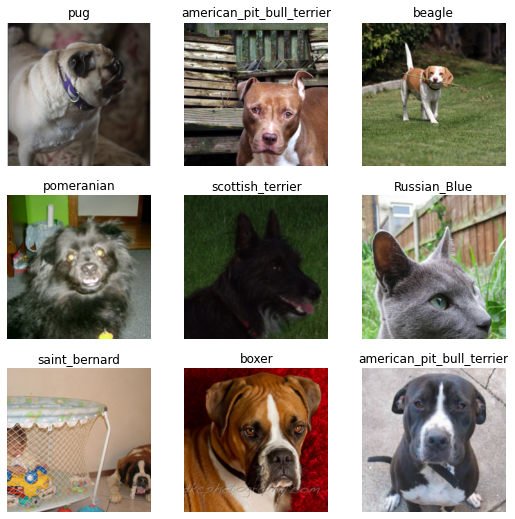

In [19]:
dls.show_batch()

##create Vision Learner to use convnext_tiny_in22k from timm.models list trained on 22000  images

In [21]:
learner = vision_learner(dls,'convnext_tiny_in22k',metrics=[accuracy,error_rate]).to_fp16()

In [22]:
learner.fine_tune(epochs=3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.070872,0.228618,0.933694,0.066306,00:57


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.298479,0.227186,0.928281,0.071719,01:59
1,0.200995,0.171366,0.943843,0.056157,01:59
2,0.124529,0.157873,0.948579,0.051421,01:59


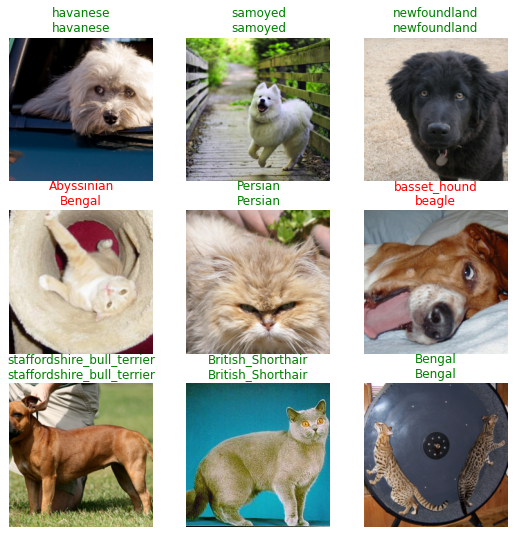

In [24]:
learner.show_results()

## loss

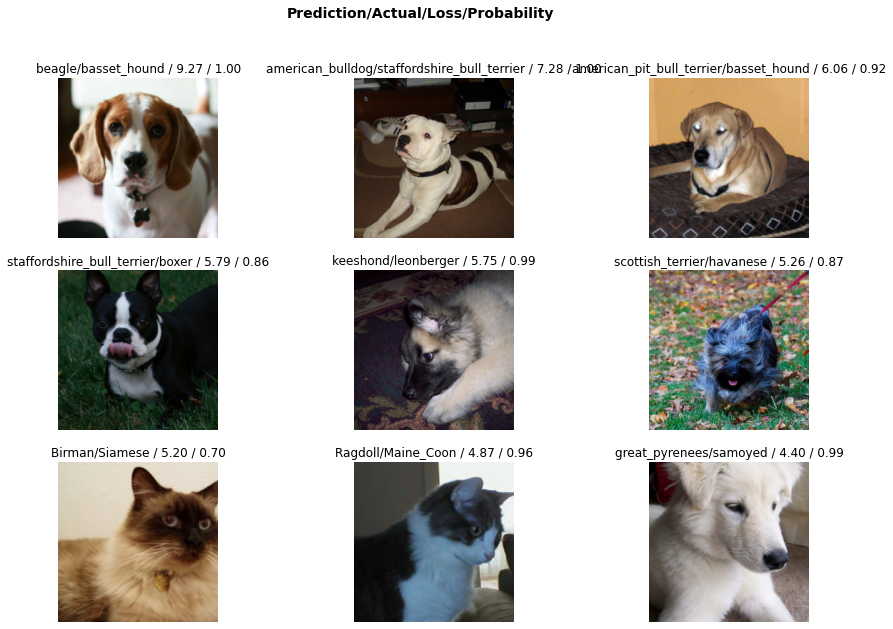

In [26]:
interp = Interpretation.from_learner(learner)
interp.plot_top_losses(9, figsize=(15,10))

## Categories stored in fastai dataloader.vocab

In [30]:
dls.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

## Save Model

In [29]:
learner.export('/content/convnext_tiny_in22k.pkl')

## Load the Model

In [31]:
learn = load_learner("/content/convnext_tiny_in22k.pkl")

## Download image

In [32]:
! pip install -q duckduckgo_search

     |████████████████████████████████| 96 kB 4.4 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [33]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [34]:
urls = search_images('german_shorthaired dog', max_images=1)
urls[0]

Searching for 'german_shorthaired dog'


'http://www.spockthedog.com/wp-content/uploads/2016/02/German-Shorthaired-Pointer.jpg'

In [35]:
from fastdownload import download_url
dest = 'german_shorthaired dog.jpg'
download_url(urls[0], dest, show_progress=False)

Path('german_shorthaired dog.jpg')

## Make Inference

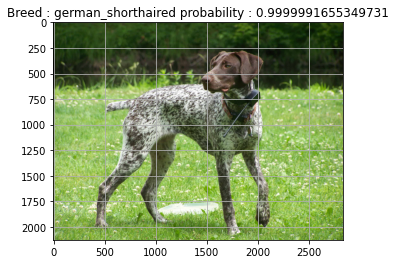

{'Abyssinian': 7.116804368045848e-11, 'Bengal': 7.906361329523826e-12, 'Birman': 1.008453823919675e-11, 'Bombay': 1.0003050471274477e-10, 'British_Shorthair': 2.6038696199215394e-10, 'Egyptian_Mau': 2.335665549857424e-10, 'Maine_Coon': 2.0290271199319143e-12, 'Persian': 1.963835344342968e-11, 'Ragdoll': 2.272133869940518e-12, 'Russian_Blue': 1.417955752813782e-10, 'Siamese': 3.2658034609944764e-10, 'Sphynx': 3.236843015841373e-10, 'american_bulldog': 1.6986941853147641e-09, 'american_pit_bull_terrier': 8.526567967237497e-07, 'basset_hound': 2.093514472889524e-09, 'beagle': 1.9883550361754487e-09, 'boxer': 2.6660493257502083e-11, 'chihuahua': 6.241094863135288e-10, 'english_cocker_spaniel': 2.897356243813931e-10, 'english_setter': 1.2127112647419835e-08, 'german_shorthaired': 0.9999991655349731, 'great_pyrenees': 1.2725773559929543e-11, 'havanese': 5.8026868032801104e-11, 'japanese_chin': 9.641749204591932e-12, 'keeshond': 1.3656761277403007e-09, 'leonberger': 2.243844172966636e-11, 'mi

'german_shorthaired'

In [42]:
from PIL import Image
categories = dls.vocab
def classify_image(img):
  pred,idx,prob = learn.predict(img)
  plt.imshow(Image.open(img))
  plt.grid('off')
  plt.title(f"Breed : {categories[idx]} probability : {prob[idx]}")
  plt.show()
  print(dict(zip(categories,map(float,prob))))
  return categories[idx]
classify_image("/content/german_shorthaired dog.jpg")

* A learner has two important things :
    - A list of preprocessing steps we did to convert images into the input format required by the model.(dataloders)
    - Trained Model and parameters

* grab the trained model attribute using the .model attribute

In [43]:
m = learn.model
m

Sequential(
  (0): TimmBody(
    (model): ConvNeXt(
      (stem): Sequential(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (stages): Sequential(
        (0): ConvNeXtStage(
          (downsample): Identity()
          (blocks): Sequential(
            (0): ConvNeXtBlock(
              (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
              (mlp): Mlp(
                (fc1): Linear(in_features=96, out_features=384, bias=True)
                (act): GELU(approximate=none)
                (drop1): Dropout(p=0.0, inplace=False)
                (fc2): Linear(in_features=384, out_features=96, bias=True)
                (drop2): Dropout(p=0.0, inplace=False)
              )
              (drop_path): Identity()
            )
            (1): ConvNeXtBlock(
              (conv_

In [46]:
l = m.get_submodule('0.model.stem.1')
list(l.parameters())

[Parameter containing:
 tensor([ 1.2553e+00,  1.9191e+00,  1.2191e+00,  1.0388e+00, -5.0983e-04,
          7.6678e-01,  8.8753e-01,  1.6321e+00,  7.0558e-01,  3.2882e+00,
          7.8627e-01,  7.6523e-05,  1.0015e+00, -2.7540e-03,  3.2968e+00,
         -6.3526e-04,  1.9846e+00,  1.0218e+00,  4.4515e+00,  2.5536e-01,
          2.7257e+00,  9.2669e-01,  1.2378e+00,  4.5810e-03,  1.7873e+00,
          5.4333e-01,  4.6261e+00,  1.2600e-02, -5.4594e-04,  3.4503e+00,
          1.3507e+00,  4.1275e+00,  2.6881e+00,  4.1204e+00,  3.4004e+00,
          8.4939e-01,  7.3595e-01,  3.9786e+00,  1.2861e+00,  6.4022e-01,
          2.6893e+00,  1.1182e+00,  1.1695e+00,  5.5292e-01,  2.3345e+00,
          1.6060e-03,  9.7029e-01,  1.5798e-03,  1.1984e+00,  1.7899e+00,
          4.0161e-01,  4.4998e-01,  9.7246e-01,  3.9892e+00,  6.5695e-01,
          6.8744e-01,  9.8506e-01,  2.7061e+00,  1.2170e+00,  7.6175e-01,
          3.3021e+00,  1.6198e+00,  9.5589e-01,  2.1204e+00,  6.2949e-01,
          4.033

## How to fit a function to a data

In [47]:
def f(x): return 3*x**2 + 2*x + 1
plot_function(f,"$3x^2 +2x + 1$")

NameError: ignored

In [48]:
def quad(a,b,c,x):return a*x**2 + b*x +c

In [50]:
quad(3,2,1,1.5)

10.75

In [49]:
from functools import partial
def make_quad(a,b,c) : return partial(quad,a,b,c)

In [51]:
f = make_quad(3,2,1)
f(1.5)

10.75

In [54]:
import numpy as np
np.random.seed(42)
def noise(x,scale):return np.random.normal(scale=scale,size=x.shape)
def add_noise(x,mult,add): return x * (1+noise(x,mult)) + noise(x,add)

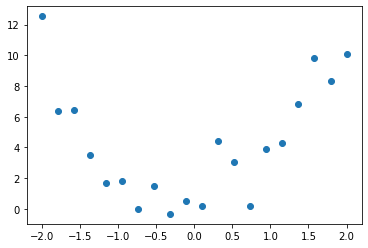

In [55]:
x = torch.linspace(-2,2,steps=20)[:None]
y = add_noise(f(x),0.3,1.5)
plt.scatter(x,y)

In [57]:
pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 6.7 MB/s 


## Automate the search of parameters for better loss

In [59]:
from ipywidgets import interact
@interact(a=1.5,b=1.5,c=1.5)
def plot_squad(a,b,c):
  plt.scatter(x,y)


interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

## Loss Function

In [60]:
def mse(preds,actuals): return ((preds - actuals)**2).mean()

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

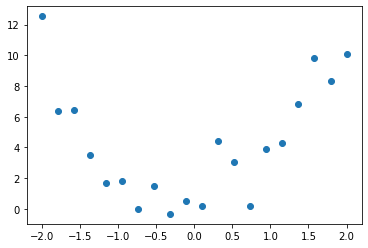

In [61]:
from ipywidgets import interact
@interact(a=1.5,b=1.5,c=1.5)
def plot_squad(a,b,c):
  plt.scatter(x,y)
  loss = mse(f(x),y)
  plt.scatter(loss,c='red')

In [62]:
def quad_mse(params):
  f = make_quad(*params)
  return mse(f(x),y)

In [63]:
quad_mse([1.5,1.5,1.5])

tensor(5.8336, dtype=torch.float64)

* 1D tensor == Rank 1 Tensor

In [101]:
#rank 1 tensor
abc = torch.tensor([1.5,1.5,1.5]).requires_grad=True
abc.requires_grad_() #calculate gradients

tensor([1.5000, 1.5000, 1.5000], requires_grad=True)

In [102]:
loss = quad_mse(abc)

In [103]:
loss.backward()

In [104]:
abc.grad

tensor([-5.1419,  2.8472, -1.1009])

In [95]:
with torch.no_grad():
  abc = abc - abc.grad * 0.01
  loss = quad_mse(abc)
  
print(f"loss = {loss:.2f}")


loss = 5.49


In [108]:
abc = torch.tensor([1.5,1.5,1.5])
abc.requires_grad_()
for i in range(5):
  loss = quad_mse(abc)
  loss.backward()
  with torch.no_grad():abc = abc - abc.grad*0.01
  print(f"step : {i} loss : {loss:.2f}")

step : 0 loss : 5.83


RuntimeError: ignored

In [109]:
def rectified_linear(m,b,x):
  y = m*x + b
  return torch.clip(y,0)

In [113]:
partial(rectified_linear,1,1)

functools.partial(<function rectified_linear at 0x7fb7b6f64d40>, 1, 1)

## Lesson 4: Practical Deep Learning for Coders 2022

## Getting started with NLP for absolute beginners

## Objective : 

* Determine if two contexts represent the same thing
* For the following text...: "TEXT1: abatement; TEXT2: eliminating process" ...chose a category of meaning similarity: "Different; Similar; Identical".

* U.S. Patent Phrase to Phrase Matching - Kaggle Dataset

In [119]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [121]:
from pathlib import Path
path = Path("/content/drive/MyDrive/NLP_Fastai")
path.ls()

(#2) [Path('/content/drive/MyDrive/NLP_Fastai/train.csv'),Path('/content/drive/MyDrive/NLP_Fastai/test.csv')]

In [122]:
import pandas as pd
import numpy as np
df = pd.read_csv(path/'train.csv')
df.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [123]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


In [124]:
df.shape

(36473, 5)

* We could represent the input to the model as something like "TEXT1: abatement; TEXT2: eliminating process". 
* We'll need to add the context to this too. In Pandas, we just use + to concatenate, like so:

In [125]:
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor
df.head()

,id,anchor,target,context,score,input
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,TEXT1: A47; TEXT2: act of abating; ANC1: abatement
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,TEXT1: A47; TEXT2: active catalyst; ANC1: abatement
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,TEXT1: A47; TEXT2: eliminating process; ANC1: abatement
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,TEXT1: A47; TEXT2: forest region; ANC1: abatement


In [126]:
df.input.head()

0    TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement
1            TEXT1: A47; TEXT2: act of abating; ANC1: abatement
2           TEXT1: A47; TEXT2: active catalyst; ANC1: abatement
3       TEXT1: A47; TEXT2: eliminating process; ANC1: abatement
4             TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object